In [1]:
import numpy as np 
import pandas as pd
import cPickle as pkl
from matplotlib import pyplot as plt
import time

import theano_time_corex
import linearcorex

import random
from scipy.stats import multivariate_normal
import sklearn.covariance as skcov
from sklearn.decomposition import FactorAnalysis

from generate_data import generate_nglf_timeseries

# Generate Data

In [2]:
nt = 100
ns = 100
m = 8
nv = m * 8 # 64

(ts_data, test_data, ground_truth) = generate_nglf_timeseries(nv, m, nt, ns, snr=5.0, min_var=1, max_var=1)

Fixed SNR: 5.0
Fixed SNR: 5.0


In [3]:
test_data.shape


(100, 100, 64)

In [4]:
ts_data.shape


(100, 64)

### Ground Truth Covariance 

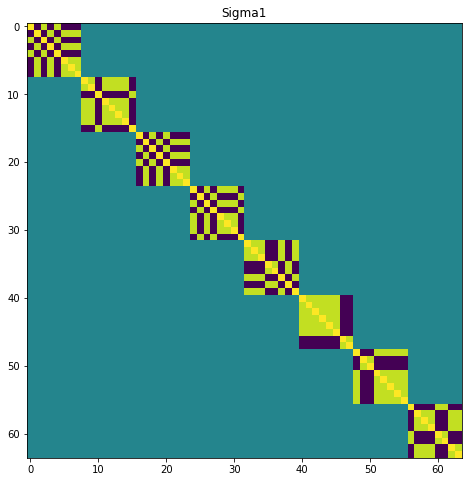

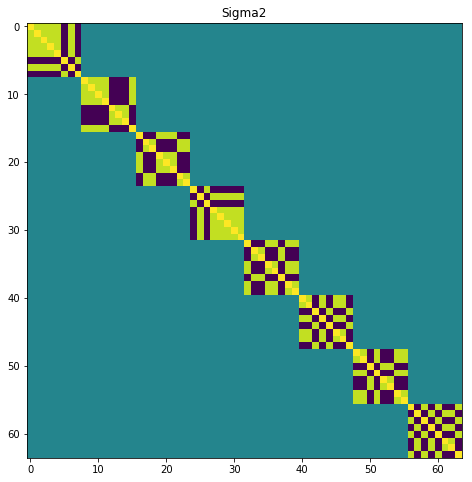

In [5]:
plt.figure(figsize=(8, 8))
plt.title("Sigma1")
plt.imshow(ground_truth[0])
plt.show()
    

plt.figure(figsize=(8, 8))
plt.title("Sigma2")
plt.imshow(ground_truth[-1])
plt.show()

### normalize data

In [6]:
# if diagonal methods work better, maybe normalization can make some problems for them ?
if False:  # if don't need to normalize, as linear corex will do it
    for t in range(nt):
        stds = np.std(Y[t], axis=0)
        X[t] /= stds
        Y[t] /= stds

### Sample covariance matrix using test data

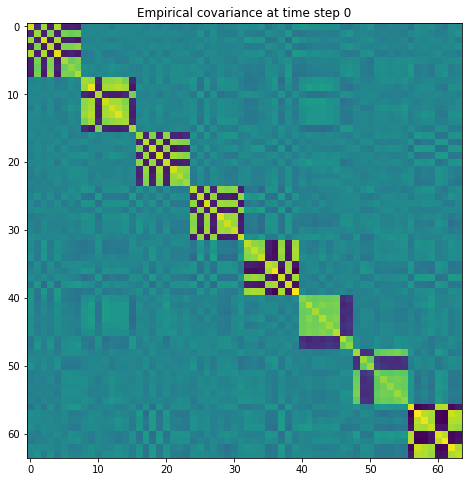

In [7]:
plt.figure(figsize=(8, 8))
plt.title("Empirical covariance at time step 0")
plt.imshow(np.cov(test_data[0].T))
plt.show()

### Some functions

In [8]:
def plot_for_next_timestep(covs, title="Negative log-likelihood of estimate of time step $t$ under the test data of timestep $t + 1$"):
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(test_data[1:], range(nt-1))]
    plt.bar(range(1, nt), nll, width=0.6)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylim(0)
    plt.ylabel("Negative log-likelihood")
    plt.xticks(range(1, nt))
    plt.show()
    print "NLL for next time step = {}".format(np.mean(nll))
    return np.mean(nll)

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [9]:
def calculate_score(covs):
    nll = [-np.mean([multivariate_normal.logpdf(sx, cov=covs[t]) for sx in x]) for x,t in zip(test_data, range(nt))]
    return np.mean(nll)

# Ground Truth Statistics

#### This graph shows how well the covariance at timestep t models the test data at timestep t+1. Clearly we should see a peak at the middle timestep.

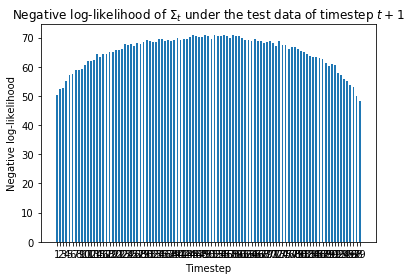

NLL for next time step = 65.1618440649


In [10]:
if ground_truth[0] is not None:
    plot_for_next_timestep(ground_truth, title="Negative log-likelihood of $\Sigma_t$ under the test data of timestep $t + 1$");

#### Negative log-likelihood of cov. estimate on each timestep. We report the sum of negative log-likelihood over timesteps.

In [11]:
if ground_truth[0] is not None:
    print "Final NLL = {}".format(calculate_score(ground_truth))

Final NLL = 64.9788905803


# Learn independent linear corexes on each timestep

In [12]:
length=21

cs = []
for i in range(len(ts_data)):
    left = max(i - length//2, 0)
    data = ts_data[left:left+length]
    c = linearcorex.Corex(n_hidden=m,
                          max_iter=500,
                          anneal=True)
    c.fit(data)
    cs.append(c)
    
print sum([c.tc for c in cs])

3375.60698223


In [13]:
cs_covs = [c.get_covariance() for c in cs]

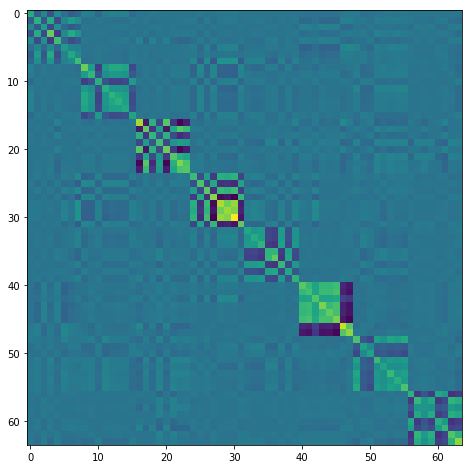

In [14]:
plt.figure(figsize=(8,8))
plt.imshow(cs_covs[0])
plt.show()

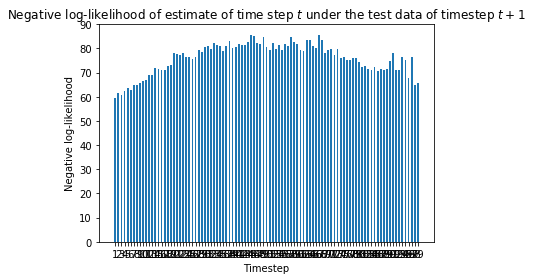

NLL for next time step = 75.9316788675


In [15]:
plot_for_next_timestep(cs_covs);

In [16]:
print "Final NLL = {}".format(calculate_score(cs_covs))

Final NLL = 75.9115027366


# L1 regularization on the difference of neighbouring covariance estimates

In [42]:
length=21
best_nll = np.inf
best_csig = None
best_l1 = None
coefs = [0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1]
#coefs = [0.01, 0.003, 0.3]
nlls = []
for l1 in coefs:
    
    X = []
    for i in range(len(ts_data)):
        left = max(i-length//2, 0)
        X.append(list(ts_data[left:left+length]))    
    
    print "training with l1 = {}".format(l1)
    csig = theano_time_corex.TimeCorexSigma(nt=nt,
                                            nv=nv,
                                            n_hidden=m,
                                            max_iter=500,
                                            verbose=False,
                                            anneal=True,
                                            l1=l1)
    csig.fit(X)
    csig_covs = csig.get_covariance()
    nll = calculate_score(csig_covs)
    nlls.append(nll)
    print "l1 = {}, nll = {}".format(l1, nll)
    if np.mean(nll) < best_nll:
        best_nll = np.mean(nll)
        best_csig = csig
        best_l1 = l1

print "best l1 = {}".format(best_l1)
csig = best_csig
print sum(csig.tc)

training with l1 = 0
Annealing iteration finished, time = 35.2688798904
Annealing iteration finished, time = 35.4118361473
Annealing iteration finished, time = 35.2833709717
Annealing iteration finished, time = 35.1376979351
Annealing iteration finished, time = 35.065639019
Annealing iteration finished, time = 35.0499489307
Annealing iteration finished, time = 35.0505731106
l1 = 0, nll = 75.3042942057
training with l1 = 1e-05
Annealing iteration finished, time = 42.3423240185
Annealing iteration finished, time = 42.6672940254
Annealing iteration finished, time = 42.6614639759
Annealing iteration finished, time = 42.8778460026
Annealing iteration finished, time = 43.095184803
Annealing iteration finished, time = 42.9371979237
Annealing iteration finished, time = 42.8473770618
l1 = 1e-05, nll = 75.3908474727
training with l1 = 3e-05
Annealing iteration finished, time = 46.0977060795
Annealing iteration finished, time = 49.3852069378
Annealing iteration finished, time = 51.1741731167
Anne

In [43]:
csig_covs = csig.get_covariance()

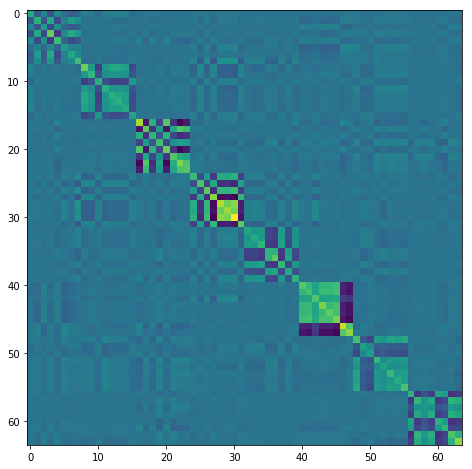

In [44]:
plt.figure(figsize=(8,8))
plt.imshow(csig_covs[0])
plt.show()

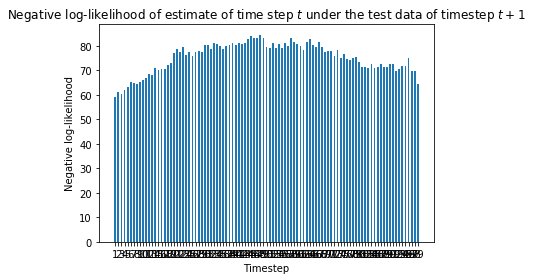

NLL for next time step = 75.2998175721


In [45]:
plot_for_next_timestep(csig_covs);

In [46]:
print "Final NLL = {}".format(calculate_score(csig_covs))

Final NLL = 75.1879137635


# Diagonal matrix

In [22]:
diag_covs = []
for x in X:
    diag_covs.append(np.diag(np.var(x, axis=0)))

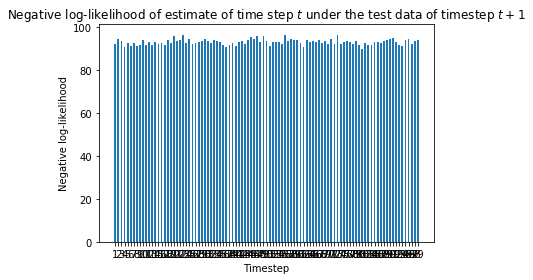

NLL for next time step = 92.9395384565


In [23]:
plot_for_next_timestep(diag_covs);

In [24]:
print "Final NLL = {}".format(calculate_score(diag_covs))

Final NLL = 92.9539938223


## Ledoit-Wolf Estimation

In [25]:
lw_covs = []
for x in X:
    lw_est = skcov.LedoitWolf()
    lw_est.fit(x)
    lw_covs.append(lw_est.covariance_)

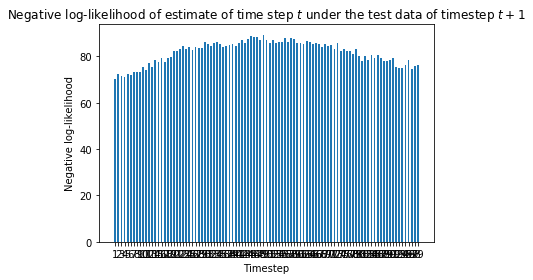

NLL for next time step = 81.7763276533


In [26]:
plot_for_next_timestep(lw_covs);

In [27]:
print "Final NLL = {}".format(calculate_score(lw_covs))

Final NLL = 81.7541502564


## Oracle Approximating Shrinkage

In [28]:
oas_covs = []
for x in X:
    oas_est = skcov.OAS()
    oas_est.fit(x)
    oas_covs.append(oas_est.covariance_)

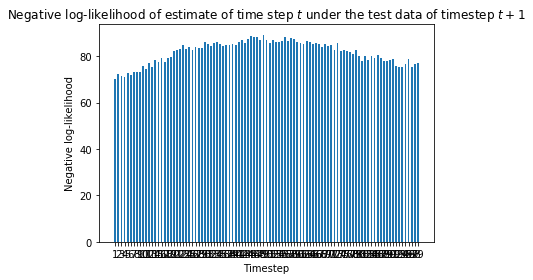

NLL for next time step = 81.7395378661


In [29]:
plot_for_next_timestep(oas_covs);

In [30]:
print "Final NLL = {}".format(calculate_score(oas_covs))

Final NLL = 81.7110374568


# Factor Analysis

In [31]:
factor_covs = []
for x in X:
    factor_est = FactorAnalysis(n_components=m)
    factor_est.fit(x)
    factor_covs.append(factor_est.get_covariance())

In [32]:
# factor_covs = [x + 1e-6 * np.eye(nv) for x in factor_covs]

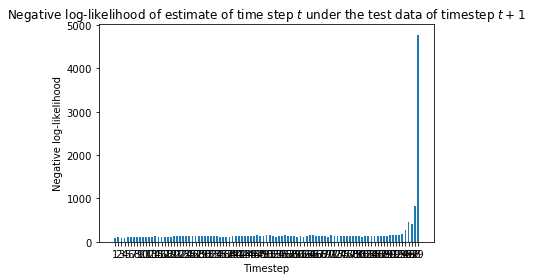

NLL for next time step = 190.359178369


In [33]:
plot_for_next_timestep(factor_covs);

In [34]:
print "Final NLL = {}".format(calculate_score(factor_covs))

Final NLL = 39428.6871738


## Graphical LASSO

In [36]:
glasso_covs = []
for x in X:
    glasso_est = skcov.GraphLasso()
    glasso_est.fit(x)
    glasso_covs.append(glasso_est.covariance_)

FloatingPointError: Non SPD result: the system is too ill-conditioned for this solver. The system is too ill-conditioned for this solver

In [ ]:
plot_for_next_timestep(glasso_covs);

In [ ]:
print "Final NLL = {}".format(calculate_score(glasso_covs))

# Summary of the results


| Model | NLL |  
|:------|----:|  
| ground truth                     | ????????? |  
| independent corexes              | 105237.22 |  
| regularized corex                |  61546.79 |  
| shrinkage estimator (coef = 0.1) | 162136.32 |
| Ledoit-Wolf                      | 52950.41  |
| OAS                              | 49325.46  |
| GLASSO                           | ill cond. |
| Emprical covariance              | ill cond. |
